# Analyze Kennicott and Root Glacier driving stress


In [1]:
### imports ###
import numpy as np
import rasterio as rio
from rasterio.windows import from_bounds
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LightSource
import statsmodels.api as sm
from osgeo import gdal
import cmocean
from raster_basics.RasterBasics import rasterMath, rasterLike, tifReprojectionResample


In [2]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'


Load data

In [3]:
dempath_38 = '/path/to/coregistered_1938_dem.tif'
dempath_57 = '/path/to/coregistered_1957_dem.tif'
dempath_78 = '/path/to/coregistered_1978_dem.tif'
dempath_2004 = '/path/to/coregistered_2004_dem.tif'
dempath_2012 = '/path/to/2012_dem.tif'
dempath_2023 = '/path/to/coregistered_2023_dem.tif'

# bed from radar data
bedpath = '/path/to/bed_elev.tif'

# factor of dataprofiles to use for any lowess filtering
lfac = .2


### Calculate basal driving stress at glacier bed, ($\tau_b$) as: $$\tau_b = \rho_i g H sin \alpha,$$ where $\rho_i$ is the density of ice (917 kg m^-3), $g$ is the acceleration due to gravity (9.81 m s^-2), $H$ is the ice thickness, and $\alpha$ is the surface slope ($^{\circ}$).

Note, it is often necessry to "de-noise" the surface slope to remove the effects of noisy surface slope feautres being imprinted on the resultant driving stress at the glacier bed.

Operationally, we will calculate the drving stress for each hhistorical digital elevation model we have available for Kennicott Glacier. For each time step where we have a DEM, we will first calculate the surface slope. The ice thickness and surface slope will then be sampled along IceBridge radar sounder profiles, assuming that the bed elevation is constant (negligible erosion).

In [4]:
# create funciton to calculate driving stress for a vector containing thickness values
def grav_driving_stress(slope, thick, rho_ice = 900, g = 9.81):
    """
    Compute driving stress at glacier bed

    Parameters
    ----------
    slope : float
      ndarray or list containing surface slope values in degrees
    thick : float
      ndarray or list containing ice thickness values in meters
    rho_ice : float
      constant ice density in kg/m^3
    g : float
      constant gravitational acceleration in m/s^2

    Returns
    -------
    tau_b : float
      ndarray containing driving stress as the product of the input parameters. Units = [m][kg/m^3][m/s^2] = [N][m^-2] = [Pa]
    """
    slope = np.asarray(slope)
    thick = np.asarray(thick)
    if slope.shape != thick.shape:
        print("Slope and thickness arrays must be of the same length")
        return None

    return rho_ice * g * thick * np.sin(np.deg2rad(slope))

def euclid_dist(xarray, yarray, zarray):
    dist = np.zeros_like(xarray)
    dist[1:] = np.cumsum(np.sqrt(np.diff(xarray) ** 2.0 + np.diff(yarray) ** 2.0 + np.diff(zarray) ** 2.0))
    return dist


Load radar data and basemap to visualize it

In [5]:
left, bottom, right, top = 558064, 1315038, 598912, 1357084 # manually defined bounds
ifsar_src = rio.open(dempath_2012,'r')
profile = ifsar_src.profile
dx, dy = round(ifsar_src.transform[0]), round(ifsar_src.transform[4])
ifsar_dem_2012 = ifsar_src.read(1, window=from_bounds(left, bottom, right, top, ifsar_src.transform))


In [6]:
# load bed data
bed_src = rio.open(bedpath)
bed = rio.open(bedpath).read(1)
bed[bed == -9999] = np.nan
bed[bed == 0] = np.nan


# load OGGM centerline

In [7]:
cl = gpd.read_file('/path/to/oggm_kennicott_centerline_smoothed.gpkg', crs='EPSG:4326').to_crs(3338)

# pack points into goepandas series and convert to epsg 3338
s = gpd.GeoSeries(map(Point, list(list(cl.iloc[0].geometry.geoms)[0].coords)), crs='EPSG:3338')

# get projected x and y coords
cl_x = s.x.to_numpy()
cl_y = s.y.to_numpy()

# get distance along prof
cl_dist = euclid_dist(cl_x, cl_y, np.zeros_like(cl_x))

# sample ifsar surface elevation along prof
coord_list = [(x, y) for x, y in zip(cl_x, cl_y)]
surface_h = np.asarray([x[0] for x in ifsar_src.sample(coord_list)])


In [8]:
# sample bed
with rio.open(bedpath,'r') as src:
    coord_list = [(x, y) for x, y in zip(cl_x, cl_y)]
    cl_bed_hgt = np.asarray([x[0] for x in src.sample(coord_list)])
cl_bed_hgt[cl_bed_hgt == -9999] = np.nan

cl_bed_hgt[cl_dist<33e3] = np.nan # i don't trust the interpolation between roughly 0 to 33 km (KENNICOTT)

# smooth bed prof
# compute a lowess smoothing of the data
smoothed_bed = sm.nonparametric.lowess(exog=cl_dist, endog=cl_bed_hgt, frac=lfac)

# make geodataframe to hold smoothed bed and surface heights we'll sample
df = pd.DataFrame({'X':cl_x, 'Y':cl_y})
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:3338")
gdf['bed_hgt'] = cl_bed_hgt
gdf['dist'] = cl_dist

# add smoothed bed to gdf
for (dist,bedhgt) in smoothed_bed:
    gdf.loc[gdf.dist==dist,'bed_hgt_lowess'] = bedhgt
    

In [9]:
# resolution to downsample dems (meters)
res = 100

# use gdal to reproject rasters to desired crs and res - the goal here being to downsample and smooth before getting slopes
options = f"-overwrite -co compress=none -of Gtiff -t_srs EPSG:3338 -tr {res} {res} -r bilinear -dstnodata -9999"
ds_in = gdal.Open(dempath_38)
ds = gdal.Warp('./1938_ds.tif', ds_in, options=options)
del ds
del ds_in

ds_in = gdal.Open(dempath_57)
ds = gdal.Warp('./1957_ds.tif', ds_in, options=options)
del ds
del ds_in

ds_in = gdal.Open(dempath_78)
ds = gdal.Warp('./1978_ds.tif', ds_in, options=options)
del ds
del ds_in

ds_in = gdal.Open(dempath_2004)
ds = gdal.Warp('./2004_ds.tif', ds_in, options=options)
del ds
del ds_in

ds_in = gdal.Open(dempath_2012)
ds = gdal.Warp('./2012_ds.tif', ds_in, options=options)
del ds
del ds_in

ds_in = gdal.Open(dempath_2023)
ds = gdal.Warp('./2023_ds.tif', ds_in, options=options)
del ds
del ds_in

ds_in = gdal.Open(bedpath)
ds = gdal.Warp('./bedpath_ds.tif', ds_in, options=options)
bedpath_ds = './bedpath_ds.tif'
del ds
del ds_in


/Users/albinwells/mambaforge/envs/pytorch_env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Get driving stress

In [10]:
# get first index where bed elevation is known and we can thus calculate the driving stress along the centerline
idx0 = np.where(~np.isnan(gdf.bed_hgt.values))[0][0]
idx1 = np.where(~np.isnan(gdf.bed_hgt.values))[0][-1]
gdf_sub = gdf.iloc[idx0:idx1+1]


Iterate through dems, smooth the surface heights, get along-track slope and calculate driving stress

In [11]:
# loop through dems
dems = ['1938_ds.tif', '1957_ds.tif','1978_ds.tif','2004_ds.tif','2012_ds.tif','2023_ds.tif']
gdf_sub = gdf_sub.copy()
for dem in dems:
    with rio.open(dem,'r') as src:
        yr = dem[:4]
        # get radar profile coords in same crs
        coord_list = [(x, y) for x, y in zip(gdf_sub["geometry"].x, gdf_sub["geometry"].y)]
        
        # sample elevation values
        arr = src.read(1)
        gdf_sub["srf_hgt_" + yr] = [x[0] for x in src.sample(coord_list)]
        
        # get lowess smoothed surface
        smoothed_surf = sm.nonparametric.lowess(exog=gdf_sub['dist'].values, endog=gdf_sub["srf_hgt_" + yr].values, frac=lfac)
        # add smoothed bed to gdf
        for (dist,srfhgt) in smoothed_surf:
            gdf_sub.loc[gdf_sub.dist==dist,'srf_hgt_lowess_' + yr] = srfhgt
        
        # check for no data vals
        gdf_sub.loc[gdf_sub["srf_hgt_" + yr]==src.nodata,["srf_hgt_" + yr]] = np.nan
        gdf_sub.loc[gdf_sub["srf_hgt_" + yr]<0,["srf_hgt_" + yr]] = np.nan
        gdf_sub.loc[gdf_sub["srf_hgt_lowess_" + yr]<0,["srf_hgt_lowess_" + yr]] = np.nan
        
        # get thickness
        gdf_sub['thick_' + yr] = gdf_sub['srf_hgt_' + yr] - gdf_sub['bed_hgt_lowess']
        
        # fit polynomial to surface_hgt to get slope over 10 m horizontal distance
        fit = np.polyfit(gdf_sub.dist, gdf_sub["srf_hgt_lowess_" + yr], 3)


In [12]:
# distances upglacier
dist_r = gdf['dist'].values[::-1]
dist_r = np.array([dist_r[0] - d for d in dist_r])
sub_dist_r = gdf_sub['dist'].values[::-1]
sub_dist_r = np.array([sub_dist_r[0] - d for d in sub_dist_r])


Now iterate through each year and calculate the driving stress along the centerline

In [13]:
# reset sub gdf distnce array so zero km is at terminus endpt
gdf_sub['dist'] = np.abs(gdf_sub['dist'] - gdf_sub['dist'].iloc[-1])


In [14]:
step = 1000 # step size (m)

dist_vls = np.arange(0,np.nanmax(gdf_sub.dist),step)
df_drivingstress = pd.DataFrame()
df_drivingstress['dist'] = dist_vls
# loop through dems
dems = ['1938_ds.tif', '1957_ds.tif','1978_ds.tif','2004_ds.tif','2012_ds.tif','2023_ds.tif']
for dem in dems:
    yr = dem[:4]

    # fit polynomial to surface_hgt to get slope over 10 m horizontal distance
    srffit = np.polyfit(gdf_sub.dist, gdf_sub["srf_hgt_lowess_" + yr], 3)
    bedfit = np.polyfit(gdf_sub.dist, gdf_sub["bed_hgt_lowess"], 3)
    df_drivingstress['srf_' + yr] = np.polyval(srffit,dist_vls)
    df_drivingstress['bed'] = np.polyval(bedfit,dist_vls)
    df_drivingstress['thick_' + yr] = df_drivingstress['srf_' + yr] - df_drivingstress['bed']
    tmp = [y - x for x, y in zip(df_drivingstress['srf_' + yr], df_drivingstress['srf_' + yr][1:])]

    # get slope in degrees of each point along centerline, by taking rise over run from each consecutive 10 m point
    slope_vls = np.rad2deg(np.arctan2([y - x for x, y in zip(df_drivingstress['srf_' + yr], df_drivingstress['srf_' + yr][1:])], np.repeat(10,len(df_drivingstress['srf_' + yr][1:]))))
    slope_vls = np.append(np.nan, slope_vls)

    df_drivingstress['slope_deg_' + yr] = slope_vls

    df_drivingstress['tau_' + yr] = grav_driving_stress(df_drivingstress['slope_deg_' + yr], df_drivingstress['thick_' + yr])

In [15]:
df_drivingstress.head()

,dist,srf_1938,bed,thick_1938,slope_deg_1938,tau_1938,srf_1957,thick_1957,slope_deg_1957,tau_1957,...,slope_deg_2004,tau_2004,srf_2012,thick_2012,slope_deg_2012,tau_2012,srf_2023,thick_2023,slope_deg_2023,tau_2023
0,0.0,496.914800,412.914262,84.000538,NaN,NaN,484.935639,72.021377,NaN,NaN,...,NaN,NaN,435.892005,22.977743,NaN,NaN,424.746192,11.831930,NaN,NaN
1,1000.0,517.468761,369.724678,147.744082,64.055956,1.172974e+06,518.321580,148.596902,73.325607,1.256795e+06,...,44.482427,4.217143e+05,448.963326,79.238648,52.582797,5.556433e+05,434.370322,64.645644,43.902723,3.957831e+05
2,2000.0,545.514851,358.817930,186.696921,70.376005,1.552606e+06,555.756278,196.938348,75.043702,1.679864e+06,...,67.335153,8.393368e+05,475.646311,116.828381,69.455475,9.658755e+05,457.819719,99.001789,66.904166,8.040288e+05
3,3000.0,578.828195,370.154339,208.673855,73.291294,1.764594e+06,595.800135,225.645796,75.978523,1.932868e+06,...,73.948825,1.072838e+06,512.615308,142.460969,74.863891,1.214153e+06,491.890219,121.735880,73.642559,1.031302e+06
4,4000.0,615.183918,393.694227,221.489691,74.620560,1.885506e+06,637.013551,243.319324,76.361360,2.087690e+06,...,76.684133,1.247103e+06,556.544667,162.850440,77.175824,1.401942e+06,533.377660,139.683433,76.448111,1.198929e+06


### Plot profile view of elevation, slope, thickness, and driving stress

In [16]:
df_tau = pd.DataFrame()
min_slope_dist = 500 # minimum horizontal distance for slope (m)

dems = ['1938_ds.tif', '1957_ds.tif','1978_ds.tif','2004_ds.tif','2012_ds.tif','2023_ds.tif']
for dem in dems:
    yr = dem[:4]
    thickness = []
    slope_vls = []
    for i, sd in enumerate(sub_dist_r):
        nearest_i = np.abs(np.array(dist_r) - sd).argmin()
        nearest_bed = np.array(gdf.bed_hgt_lowess[::-1])[nearest_i]
        sfc = np.array(gdf_sub['srf_hgt_lowess_' + yr][::-1])[i]
        thickness.append(sfc - nearest_bed)

    df_tau['thick_' + yr] = thickness

    # get slope in degrees of each point along centerline, by taking rise over run from each consecutive 10 m point
    sfc = np.array(gdf_sub['srf_hgt_lowess_' + yr][::-1])
    for i in range(len(sub_dist_r)):
        j, dsdr = 0, 0

        while dsdr <= min_slope_dist:
            j += 1
            i1 = min(i + j, len(sub_dist_r) - 1)
            i2 = max(i - j, 0)
            if i == 0:
                dsdr = sub_dist_r[i1] - sub_dist_r[i]
                dsfc = sfc[i1] - sfc[i]
            elif i == len(sub_dist_r)-1:
                dsdr = sub_dist_r[i] - sub_dist_r[i2]
                dsfc = sfc[i] - sfc[i2]
            else:
                dsdr = sub_dist_r[i1] - sub_dist_r[i2]
                dsfc = sfc[i1] - sfc[i2]

        slope_vls.append(np.rad2deg(np.arctan2(dsfc, dsdr)))

    df_tau['slope_deg_' + yr] = slope_vls
    df_tau['tau_' + yr] = grav_driving_stress(df_tau['slope_deg_' + yr], df_tau['thick_' + yr])


In [17]:
# for plotting: filter beyond a distance threshold (m). None if no filtering
filt = [5000, None, None, None, None, None] # 1938, 1957, 1978, 2004, 2012, 2023
filt = [float('inf') if x is None else x  for x in filt]


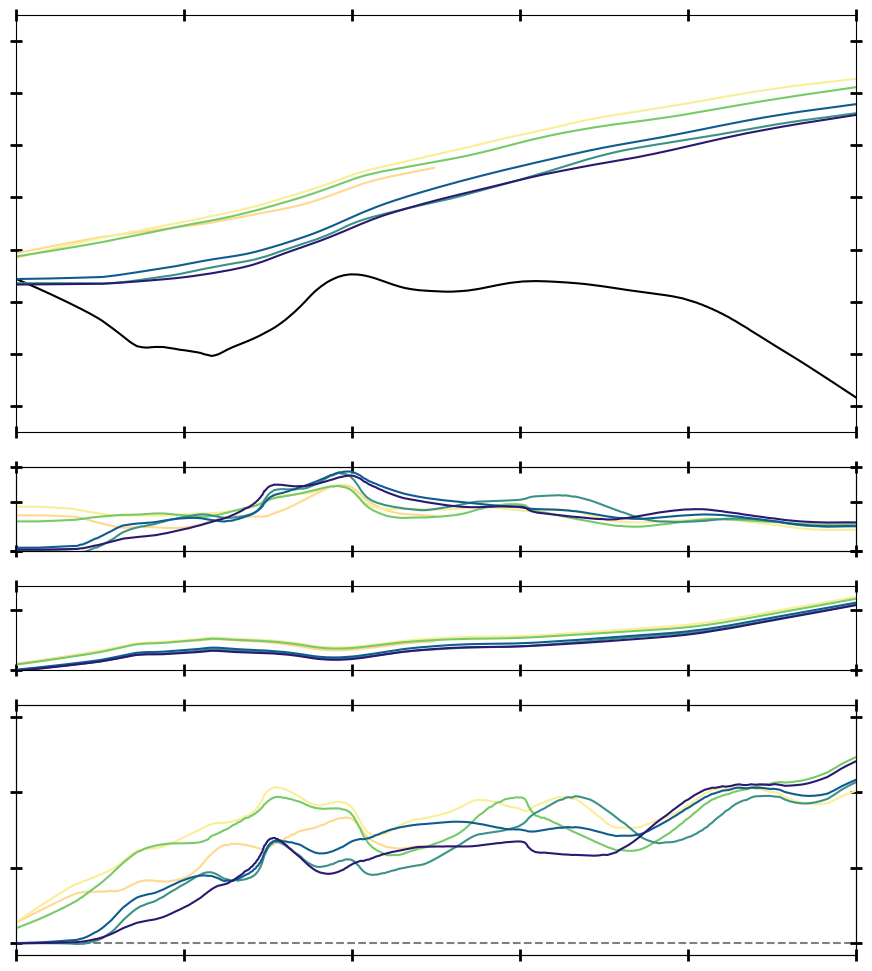

In [18]:
# plot
fig, (ax, ax2t, ax3, ax4t) = plt.subplots(nrows=4, ncols=1, figsize=(9, 10), sharex=True, height_ratios=[5, 1, 1, 3])
ax2 = ax2t.twinx()
ax2t.tick_params(top=False, left=False, right=False, labelleft=False, labeltop=False, labelright=False)
ax4 = ax4t.twinx()
ax4t.tick_params(top=False, left=False, right=False, labelleft=False)
ax4.axhline(y=0, c='k', ls='--', alpha=0.5)

# plot surfaces
# ax.plot(dist_r*1e-3, gdf.bed_hgt[::-1], ls=':', color='k') # bed elevation
ax.plot(dist_r*1e-3, gdf.bed_hgt_lowess[::-1], label='Bed', c='k') # c='tab:brown' # smooth bed elevation

# get unique colors based on number of dems
colors = ['#d0d1e6', '#a6bddb', '#74a9cf','#0570b0', '#045a8d', '#023858'][:len(dems)]
colors = cmocean.cm.haline_r(np.linspace(0.01, 0.99, len(dems)-1))
colors = np.vstack([mcolors.to_rgba('#fed98e'), colors])

for i, dem in enumerate(dems):
    yr = dem[:4]
    ax.plot(sub_dist_r[sub_dist_r<filt[i]]*1e-3, gdf_sub['srf_hgt_lowess_' + yr][::-1][sub_dist_r<filt[i]],
            c=colors[i], label=yr + ' surface') # DEM surfaces
    # ax.plot(sub_dist_r[sub_dist_r<filt[i]]*1e-3, gdf_sub['srf_hgt_' + yr][::-1][sub_dist_r<filt[i]],
    #         c=colors[i], ls=':') # smoothed DEM surfaces

# add slope, thickness, and driving stress plot
yrs = np.arange(int(dems[0][:4]), int(dems[-1][:4]) + 1)
j = 0

for i, yr in enumerate(yrs):
    dem = str(yr)+'_ds.tif'
    if dem not in dems:
        continue

    ax2.plot(sub_dist_r[sub_dist_r<filt[j]]*1e-3, df_tau['slope_deg_' + str(yr)][sub_dist_r<filt[j]], c=colors[j], ls='-', label=str(yr))
    ax3.plot(sub_dist_r[sub_dist_r<filt[j]]*1e-3, df_tau['thick_' + str(yr)][sub_dist_r<filt[j]], c=colors[j], ls='-', label=str(yr))
    # ax4.plot(df_drivingstress.dist*1e-3, 1e-3*df_drivingstress['tau_' + str(yr)], c=colors[j], ls='-', label=str(yr))
    ax4.plot(sub_dist_r[sub_dist_r<filt[j]]*1e-3, 1e-3*df_tau['tau_' + str(yr)][sub_dist_r<filt[j]], c=colors[j], ls='-', label=str(yr))
    j += 1

# settings
ax.tick_params(which='both', left=True, right=True, bottom=True, top=True, direction='inout', length=8, width=2)
ax2.tick_params(which='both', left=True, right=True, bottom=True, top=True, direction='inout', length=8, width=2)
ax2t.tick_params(which='both', left=True, right=True, bottom=True, top=True, direction='inout', length=8, width=2)
ax3.tick_params(which='both', left=True, right=True, bottom=True, top=True, direction='inout', length=8, width=2)
ax4.tick_params(axis='y', which='both', left=True, right=True, direction='inout', length=8, width=2)
ax4t.tick_params(axis='x', which='both', bottom=True, top=True, direction='inout', length=8, width=2)

# Add axis labels
# ax.set_ylabel('Elevation (m)')
# ax2.set_ylabel('Slope (°)')
# ax3.set_ylabel('Thickness (m)')
# ax4.set_ylabel('Driving stress (kPa)')
# ax4t.set_xlabel('Distance upglacier (km)')

# ax2.set_xlim([31,ax.get_xlim()[1]])
# ax.set_xlim([0,np.max(sub_dist_r)*1e-3])
ax.set_xlim([0,10])
ax.set_ylim([150,950])
ax2.set_ylim(0,)
ax3.set_ylim([0,700])
ax.plot([],[],label='Non-smoothed', ls=':', c='k')
# ax.legend(loc='upper left')

for axi in [ax,ax2,ax3,ax4,ax2t,ax4t]:
    axi.tick_params(labelleft=False, labelright=False, labelbottom=False)
    
fig.tight_layout()


In [19]:
# get driving stress at specific points
for km in range(12):
    m = km*1e3
    km_i = min(range(len(sub_dist_r)), key=lambda i: abs(sub_dist_r[i] - m))
    print('\nDriving Stress at', km, 'km (kPa):')
    for i, yr in enumerate(yrs):
        dem = str(yr)+'_ds.tif'
        if dem not in dems:
            continue
        print('\t' + str(yr) +':', round(1e-3*df_tau['tau_' + str(yr)][km_i]))



Driving Stress at 0 km (kPa):
	1938: 14
	1957: 14
	1978: 10
	2004: 0
	2012: 0
	2023: 0

Driving Stress at 1 km (kPa):
	1938: 34
	1957: 45
	1978: 39
	2004: 3
	2012: 9
	2023: 3

Driving Stress at 2 km (kPa):
	1938: 43
	1957: 70
	1978: 66
	2004: 39
	2012: 42
	2023: 24

Driving Stress at 3 km (kPa):
	1938: 63
	1957: 101
	1978: 94
	2004: 63
	2012: 64
	2023: 68

Driving Stress at 4 km (kPa):
	1938: 82
	1957: 89
	1978: 85
	2004: 55
	2012: 68
	2023: 53

Driving Stress at 5 km (kPa):
	1938: 65
	1957: 84
	1978: 66
	2004: 56
	2012: 80
	2023: 64

Driving Stress at 6 km (kPa):
	1938: 85
	1957: 89
	1978: 97
	2004: 78
	2012: 75
	2023: 67

Driving Stress at 7 km (kPa):
	1938: 55
	1957: 82
	1978: 65
	2004: 90
	2012: 73
	2023: 59

Driving Stress at 8 km (kPa):
	1938: 52
	1957: 92
	1978: 83
	2004: 70
	2012: 90
	2023: 95

Driving Stress at 9 km (kPa):
	1938: 48
	1957: 100
	1978: 106
	2004: 97
	2012: 102
	2023: 105

Driving Stress at 10 km (kPa):
	1938: 62
	1957: 101
	1978: 123
	2004: 107
	2012: 108
	2023